## Tokenization Practice and Simple Document Similarity

For this notebook, you have been provided the top 50 most downloaded books from Project Gutenberg over the last 90 days as text files.

In [1]:
import re
import glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

from collections import Counter

Given a filepath, you can open the file and use the `read` method to extract the contents as a string.

For example, if we want to import the full text of War and Peace, we can do that using the following block of code.

In [3]:
filepath = 'books/War and Peace by graf Leo Tolstoy.txt'

with open(filepath, encoding = 'utf-8') as fi:
    book = fi.read()

You'll notice that there is some metadata at the top of the file and at the bottom of the file.

In [ ]:
book[:1000]

In [ ]:
book[-18420:-18000]

Write some code that will remove this text at the bottom and top of the string.

**Hint:** You might want to make use of the [`re.search`](https://docs.python.org/3/library/re.html#re.search) function from the `re` library.

First attempt:

In [ ]:
pat1 = r'.*\*\*\*\n\n\n\n\n'
header = re.search(pat1, book, re.DOTALL)
header = header.group()

In [ ]:
pat2 = r'\n\n\n\n\n\*\*\*.*'
footer = re.search(pat2, book, re.DOTALL)
footer = footer.group()

In [ ]:
book = book.replace(header, '')
book = book.replace(footer, '')
book = book.replace('\n', ' ')

Better:

In [ ]:
pat = r'(?<=\*\*\*\n\n)(?:(?!\n\n\n\n\n\*\*\*).)*'
re.search(pat, book, re.DOTALL).group()

If we want to be able to scale up our analysis to multiple books, it would be nice to have a function to use repeatedly. Write a function called `import_book` which takes as an argument a filepath and returns the contents of that file as a string with the metadata at the top and bottom removed.

In [ ]:
def import_book(filepath):
    book = open(filepath, encoding = 'utf-8').read()
    pat1 = r'.*\*\*\*\n\n'
    header = re.search(pat1, book, re.DOTALL)
    header = header.group()
    pat2 = r'\n\n\n\n\n\*\*\*.*'
    footer = re.search(pat2, book, re.DOTALL)
    footer = footer.group()
    book = book.replace(header, '')
    book = book.replace(footer, '')
    book = book.replace('\n', ' ')
    return book

Use this, it's tidier:

In [5]:
def import_book(filepath):
    book = open(filepath, encoding = 'utf-8').read()
    pat = r'(?<=\*\*\*\n\n)(?:(?!\n\n\n\n\n\*\*\*).)*'
    book = re.search(pat, book, re.DOTALL).group()
    book = book.replace('\n', ' ')
    return book

In [ ]:
filepath = 'books/War and Peace by graf Leo Tolstoy.txt'

import_book(filepath)

Now, let's utilize our function to import all of the books into a data structure of some kind.

First, we need to be able to iterate through the list of filepaths. For this, we can use the `glob` function. This function takes as agument a pattern to match. Try it out.

In [ ]:
glob.glob('books/*.txt')

In [ ]:
filepath = glob.glob('books/*.txt')[-2]
filepath

In [ ]:
import_book(filepath)

It would be nice to save the title of each book without the extra pieces around it. Write code that will remove the "books/" from the front of the filepath and the ".txt" from the end. That is, we want to extract just the "Little Women by Louisa May Alcott" from the current filepath.

In [ ]:
pattern = r'(?<=books\\)(?:(?!\.txt).)*'
filepath = re.search(pattern, filepath).group()
filepath

Now, combine together the function you created and the code that you just wrote to iterate through the filepaths for the books and save the contents of each book into a dictionary whose keys are equal to the cleaned up titles.

In [7]:
books = {}
pattern = r'(?<=books\\)(?:(?!\.txt).)*'
all_filepaths = glob.glob('books/*.txt')
for path in all_filepaths:
    title = re.search(pattern, path).group()
    book = import_book(path)
    books.update({title : book})

Now let's write some code so that we can cluster our books. In order to cluster, we'll need to be able to compute a similarity or distance between books.

A simple way to compute similarity of documents is the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) of the set of words that they conain. This metric computes the amount of overlap between two sets compared to their union. Two books which contain exactly the same words (but not necessarily in the same order or with the same frequency) will have a Jaccard similarity of 1 and two books which have no words in common will have a Jaccard similarity of 0.

**Question:** What might be some of the downsides to using Jaccard similarity to compute the similarity of two books?

In order to use this, we'll need to tokenize each book and store the results in a collection of some kind. Since we are interested in which words appear but not necessarily in what order or how frequently, we can make use of a [set](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset). A set is similar to a list, but the order of the contents does not matter and a set cannot contain duplicates.

For practice, let's grab one of our books.

In [21]:
book = books['Little Women by Louisa May Alcott']

Write some code which tokenizes Little Women and stores the tokens it contains in a set. It is up to you to decide exactly how you want to tokenize or what you want to count as a token.

Once you are happy with your tokenization method, convert it into a function named `tokenize_book` which takes in a string and returns a set of tokens.

In [104]:
def tokenize_book(text):
    book = set([x.lower() for x in regexp_tokenize(text, r'\w{2,}') if x.lower() not in set(stopwords.words('english'))])
    return book

Now, write a function `jaccard` which takes in two sets of tokens and returns the Jaccard similarities between them. **Hint:** Python sets have `intersection` and `union` methods.

In [116]:
# Jaccard index = the intersection size divided by the union size
# x.intersection(y) OR x & y
def jaccard(set1, set2):
    jaccard_index = len(set1 & set2) / len(set1 | set2)
    return jaccard_index 

Is Little Women more similar (using Jaccard Similarity) to Heart of Darkness or Anthem?

In [87]:
books.keys()

dict_keys(['A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens', 'A Modest Proposal by Jonathan Swift', 'A Tale of Two Cities by Charles Dickens', 'Adventures of Huckleberry Finn by Mark Twain', 'Ang Filibusterismo', 'Anna Karenina by graf Leo Tolstoy', 'Anne of Green Gables by L. M.  Montgomery', 'Anthem by Ayn Rand', 'Crime and Punishment by Fyodor Dostoyevsky', 'Don Quixote by Miguel de Cervantes Saavedra', 'Dracula by Bram Stoker', 'Dubliners by James Joyce', 'Emma by Jane Austen', 'Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley', 'Great Expectations by Charles Dickens', 'Heart of Darkness by Joseph Conrad', 'Jane Eyre_ An Autobiography by Charlotte Brontë', 'Japanese Girls and Women by Alice Mabel Bacon', 'Les Misérables by Victor Hugo', 'Leviathan by Thomas Hobbes', 'Little Women by Louisa May Alcott', 'Metamorphosis by Franz Kafka', 'Moby Dick; Or, The Whale by Herman Melville', 'Narrative of the Life of Frederick Douglass, an

In [106]:
little_women_token = tokenize_book(books['Little Women by Louisa May Alcott'])
heart_darkness_token = tokenize_book(books['Heart of Darkness by Joseph Conrad'])
anthem_token = tokenize_book(books['Anthem by Ayn Rand'])

In [118]:
print(jaccard(little_women_token, heart_darkness_token))
print(jaccard(little_women_token, anthem_token))

0.2583221317308453
0.13106136137043414


Let's create another dictionary called `book_tokens` that contains the title of each book as a key and the tokenized version of the book as values.

In [124]:
book_tokens = {}
for key, value in books.items():
    book_tokens[key] = tokenize_book(value)

Using this, let's create a distance matrix for our books using the jaccard function above. **Note:** You created a function for jaccard _similarity_. This can be converted to a **distance** by subtracting the similarity score from 1.

In [126]:
dists = np.zeros(shape = (len(book_tokens), len(book_tokens)))

Now, fill in the distance matrix so that in the i,j spot you have one minus the jaccard similarity of the ith and jth books.

In [374]:
for c in range (len(book_tokens)):
    for r in range (len(book_tokens)):
        dists[c][r] = 1 - (jaccard(list(book_tokens.values())[c], list(book_tokens.values())[r]))

In [376]:
dists

array([[0.        , 0.89182744, 0.72728962, ..., 0.77869642, 0.82051563,
        0.7360913 ],
       [0.89182744, 0.        , 0.9273539 , ..., 0.93373919, 0.95393725,
        0.92634471],
       [0.72728962, 0.9273539 , 0.        , ..., 0.67399949, 0.66153693,
        0.61654246],
       ...,
       [0.77869642, 0.93373919, 0.67399949, ..., 0.        , 0.68566813,
        0.68439164],
       [0.82051563, 0.95393725, 0.66153693, ..., 0.68566813, 0.        ,
        0.67693228],
       [0.7360913 , 0.92634471, 0.61654246, ..., 0.68439164, 0.67693228,
        0.        ]])

Once we have our distance matrix, we can compute a **dendogram**. 

A dendogram is a way to visualize a hierarchical clustering of a dataset. You can read more about it [here](https://www.statisticshowto.com/hierarchical-clustering/).

In [160]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Maria\\Downloads\\NSS Data Science Bootcamp\\NLP\\projects\\nlp-01-tokenization-mariacancodenow\\notebooks\\images\\dendogram_complete_jaccard.png'

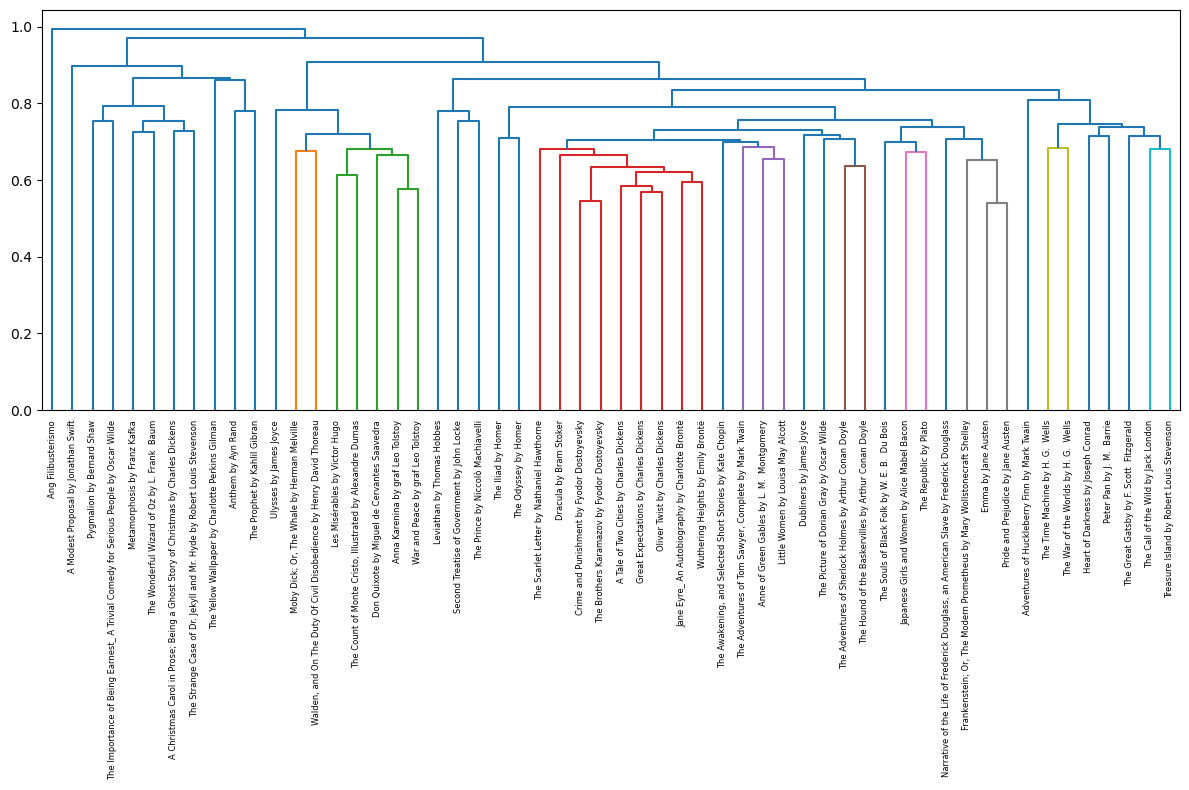

In [378]:
mergings = linkage(squareform(dists), method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(book_tokens.keys()),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()
plt.savefig('images/dendogram_complete_jaccard.png', transparent=False, facecolor='white', dpi = 150);

**Bonus Material** Jaccard Similarity does not account for the frequency that each word is used, only whether or not it is used.

We might be better off using the **cosine similarity** as a way to measure the similarity of two books.

Create a dataframe named `books_df` where each row corresponds to a book and each column corresponds to a word. It should count the number of times the word appears in that book (including zero). Use the book title as the index of this dataframe.

In [396]:
def token_counter(text):
    book_counter = Counter([x.lower() for x in regexp_tokenize(text, r'\w{2,}') if x.lower() not in set(stopwords.words('english'))])
    return book_counter

In [400]:
book_counter = {}
for key, value in books.items():
    book_counter[key] = token_counter(value)

In [406]:
books_df = pd.DataFrame.from_dict(book_counter, orient='index')
books_df = books_df.replace(np.nan, 0)

In [410]:
from sklearn.metrics.pairwise import cosine_similarity

In [515]:
cosine_dists = np.zeros(shape = (len(books_df), len(books_df)))
cosine_sims = np.zeros(shape = (len(books_df), len(books_df)))

In [517]:
for c in range (len(books_df)):
    for r in range (len(books_df)):
        x = books_df.iloc[[c]]
        y = books_df.iloc[[r]]
        cosine_sims[c][r] = cosine_similarity(x, y)
        cosine_sims[c][r] = round(cosine_sims[c][r], 2)
        cosine_dists[c][r] = 1 - (cosine_sims[c][r])

C:\Users\Maria\AppData\Local\Temp\ipykernel_4544\2690183382.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cosine_sims[c][r] = cosine_similarity(x, y)
C:\Users\Maria\AppData\Local\Temp\ipykernel_4544\2690183382.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cosine_sims[c][r] = cosine_similarity(x, y)
C:\Users\Maria\AppData\Local\Temp\ipykernel_4544\2690183382.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cosine_sims[c][r] = cosine_similarity(x, y)
C

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Maria\\Downloads\\NSS Data Science Bootcamp\\NLP\\projects\\nlp-01-tokenization-mariacancodenow\\notebooks\\images\\dendogram_complete_jaccard.png'

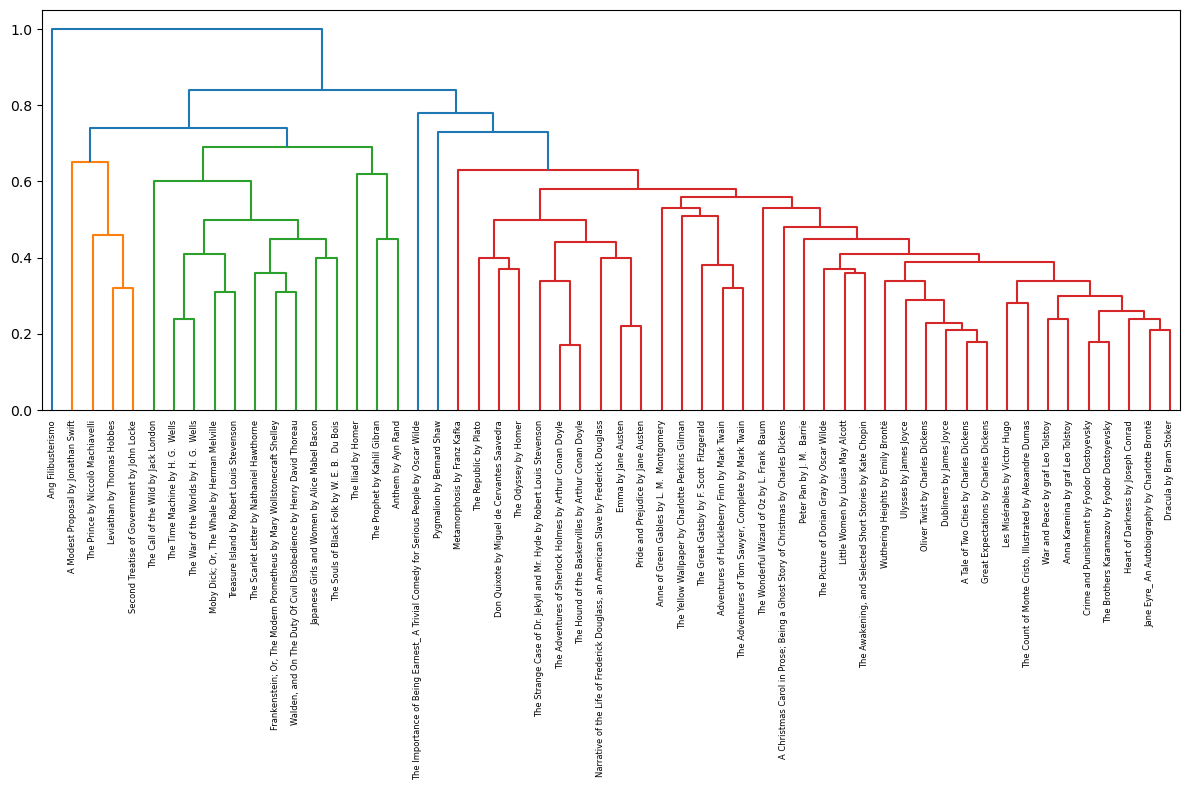

In [523]:
mergings = linkage(squareform(cosine_dists), method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(books_df.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()
plt.savefig('images/dendogram_complete_jaccard.png', transparent=False, facecolor='white', dpi = 150);